# **Classical Image Segmenatation**

## **1. N-cut Algorithm**

In [ ]:
import cv2
import torch
import matplotlib as plt
from google.colab.patches import cv2_imshow
import math
import numpy as np

In [ ]:
from cv2 import cvtColor
from cv2 import COLOR_BGR2HSV

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

In [ ]:
img1 = cv2.imread('/content/img1.jpeg')
img2 = cv2.imread('/content/img2.jpeg')
img3 = cv2.imread('/content/img3.jpeg')
img4 = cv2.imread('/content/img4.jpeg')

## **1.   N-cut Algorithm**

### Calculation of Degree and Similarity Matix

In [ ]:
def get_W_D(image):

  flat_image = image.reshape(-1)

  m, n = image.shape
  N = int(image.size)
  r = 6
  sig_dist = 7
  sigma_I = 10
  sigma_X = 5.0
  F = image

  coordinate_grid = np.array(np.meshgrid(range(0, flat_image.shape[0]), range(0, flat_image.shape[0]), indexing='ij'))
  XYarray = np.array([coordinate_grid[0].ravel(), coordinate_grid[1].ravel()])
  X_array, Y_array = np.array(XYarray[0], dtype = int), np.array(XYarray[1], dtype = int)
  dist = ((X_array//n - Y_array//n)**2 + (X_array%n - Y_array%n)**2)
  dist_e = np.exp(-dist/(sig_dist**2))
  W_values = np.exp(-(flat_image[X_array] - flat_image[Y_array])**2/(sigma_I**2))*dist_e
  list_XY = np.where( dist.reshape(m*n, m*n) < r**2 )
  W_values = csr_matrix((W_values.reshape(m*n, m*n)[list_XY[0], list_XY[1]], (list_XY[0], list_XY[1])),
                        shape=(flat_image.shape[0], flat_image.shape[0]));
  print(list_XY[0].shape)
  d = np.sum(W_values.toarray(), axis = 1).reshape(m*n)
  # D = csr_matrix((d, (range(flat_image.shape[0]), range(flat_image.shape[0]))),
  #                shape=(flat_image.shape[0], flat_image.shape[0]))

  print("weight matrix computation completed :")
  return W_values, d

### Helper Functions

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

In [ ]:
def downsample(img, downsampling_factor):
  return img[::downsampling_factor, ::downsampling_factor]

In [ ]:
down = {"/content/img1.jpeg": 20,
        "/content/img2.jpeg": 15,
        "/content/img3.jpeg": 3,
        "/content/img4.jpeg": 5}

r = 10
sigma_dist = 8
image = "/content/img1.jpeg"
image_og = (plt.imread(image))
if len(image_og.shape)>1:
  image_c = np.array(image_og)
  image_b = np.array(rgb2gray(image_og))
image_c = downsample(image_c, down[image])
image_b = downsample(image_b, down[image])
m, n, c = image_c.shape
print(m,n,c)

# DEFINE SIMILARITY MATRIX
# "HVS VALUES" of the pixels
sigma_hsv = 15
image_HSV = cvtColor(image_c, COLOR_BGR2HSV)
# print(image_HSV)

26 45 3


### Eigenvalue Calculation

In [ ]:
W, d = get_W_D(image_b)
# print(W)
D = csr_matrix((d.tolist(), (range(m*n), range(m*n))), shape=(m*n, m*n))
e, V = eigsh(D-W, k=3, M=D, which = "SA" ) #
print('Eigen value computation completed :')

(108716,)
weight matrix computation completed :
Eigen value computation completed :


### Display the segmentation

0.0019041401245127845
-0.0009407170679042958


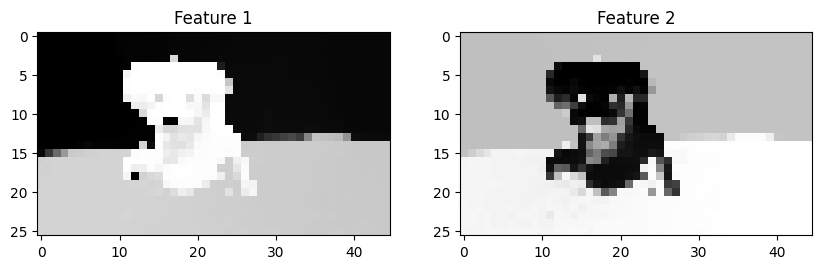

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
color = [[255,0,0], [0, 255, 0], [0, 0, 255]]
I = np.zeros((len(V), 3), float)
for i in range(1, 3, 1):
  avg = np.sum(V[:,i])/len(V)
  print(avg)
  I[np.where(V[:,i]<0)] += color[i]
  axs[i-1].imshow(V[:,i].reshape((m,n)), cmap = 'gray')
  axs[i-1].set_title("Feature {}".format(i))
plt.show()

## **2.   K-means Algorithm**


### Pixel Class with different attributes

In [ ]:
class data_point():
  def __init__(self,location,value,cluster = None):
    self.location = location
    self.value = value
    self.cluster = cluster

### Helper Functions

In [ ]:
def create_data_points(image):
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  data_point_arr = []
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      new_point = data_point([i,j],image[i][j])
      data_point_arr.append(new_point)
  return data_point_arr

In [ ]:
def assignment_to_cluster(pixel_arr,mean_arr):
  for pixel in pixel_arr:
    min = float('inf')
    for i , cluster_mean in enumerate(mean_arr):
      distance = (pixel.value - mean_arr[i])**2
      if distance < min:
        min = distance
        pixel.cluster = i
  return pixel_arr

In [ ]:
def update_mean(pixel_arr,mean_arr):
  for i , mean in enumerate(mean_arr):
    sum = 0 ; count = 0
    for pixel in pixel_arr:
      if pixel.cluster == i:
        count +=1
        sum += pixel.value
    if count != 0:
      new_mean = sum/count
      mean_arr[i] = new_mean
  return mean_arr


### Main Function

In [ ]:
def k_means_segmented_image(image,num_of_clusters,precision = 2):
  pixel_array = create_data_points(image)
  ic = 1
  k_means_arr = np.around(np.random.uniform(0,255,size = (num_of_clusters,)),decimals = precision)

  while True:
    assignment_to_cluster(pixel_array , k_means_arr)
    new_mean_arr = update_mean(pixel_array, k_means_arr)
    are_equal = np.array_equal(new_mean_arr, k_means_arr)
    if are_equal:
      break
    else:
      k_means_arr = new_mean_arr
  return pixel_array

### View Segmented Image

In [ ]:
def visualise_k_means_segmented_image(img_arr,org_image):
  pixel_coordinates = [(i, j) for i in range(org_image.shape[0]) for j in range(org_image.shape[1])]
  color_mapping = {
      0: (255, 0, 255),
      1: (0, 255, 255),
      2: (255, 255, 0),
      3: (255,0,0),
      4: (0,255,0),
      5: (0,0,255)
  }
  image = np.zeros((org_image.shape[0], org_image.shape[1], org_image.shape[2]), dtype=np.uint8)

  attribute_values = [point.cluster for point in img_arr]
  for (x, y), attr_value in zip(pixel_coordinates, attribute_values):
      color = color_mapping[attr_value]
      image[x, y] = color
  cv2_imshow(image)


### Segment and Show

In [ ]:
def segment_and_show(image,num_clusters):
  print(f"ORIGINAL IMAGE")
  print('\n')
  cv2_imshow(image)
  print('\n\n')
  segmented_image = k_means_segmented_image(image,num_clusters)
  print(f'SEGMENTED IMAGE; Number of segments: {num_clusters}')
  print('\n')
  visualise_k_means_segmented_image(segmented_image,image)

Choose any image(img1,img2,img3,img4) and
numberr of segments (3,4,5,6)

ORIGINAL IMAGE




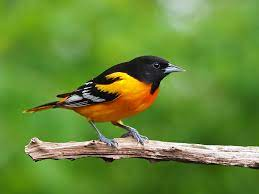




SEGMENTED IMAGE; Number of segments: 4




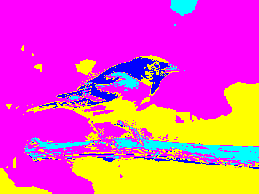

In [ ]:
segment_and_show(img4,4)

## **`RESULTS`**

Run the code to see the segmented images

Original Image 1




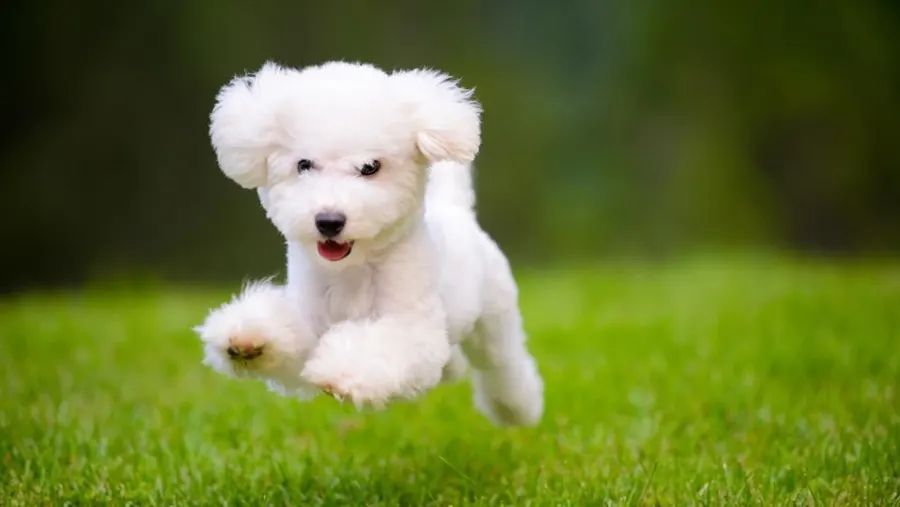






Image: 1 , Number of segments: 3




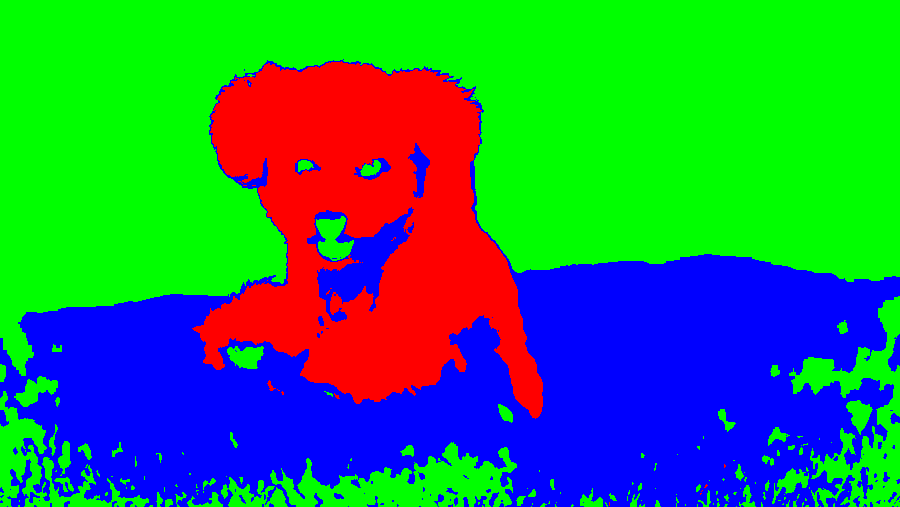




Image: 1 , Number of segments: 4




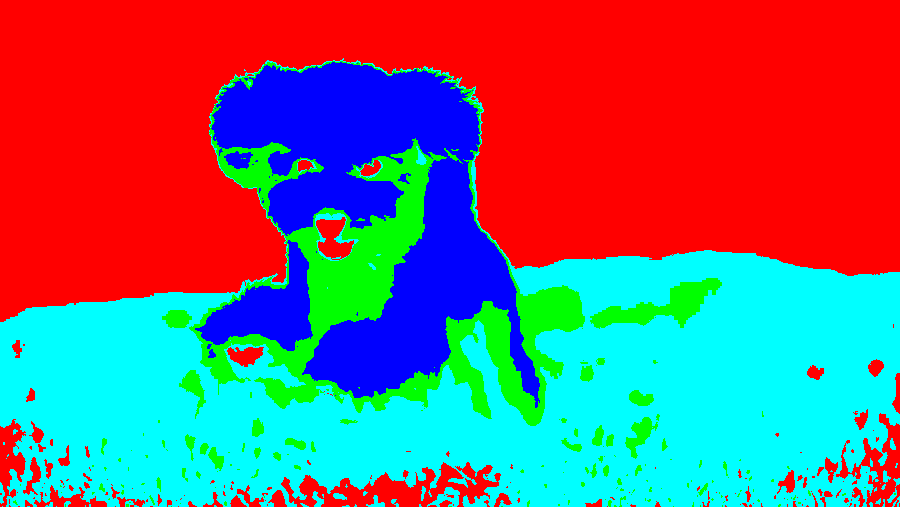




Image: 1 , Number of segments: 5




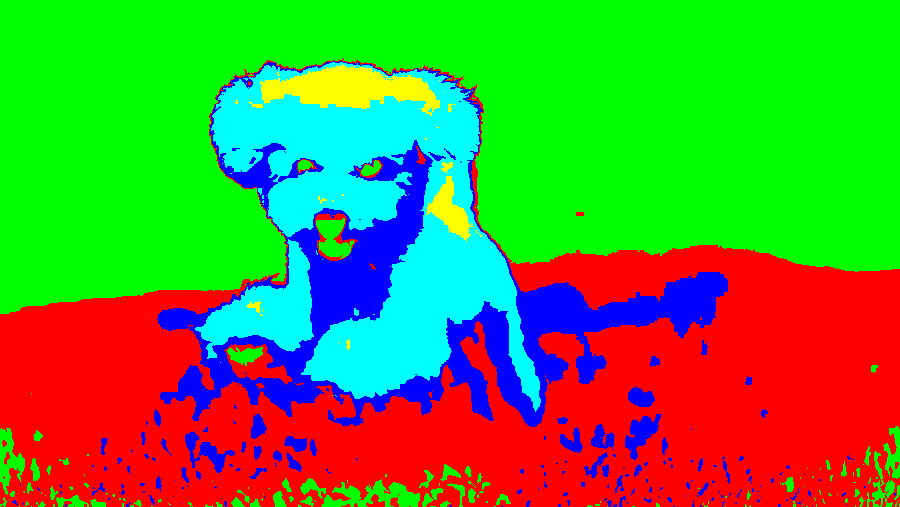




Image: 1 , Number of segments: 6




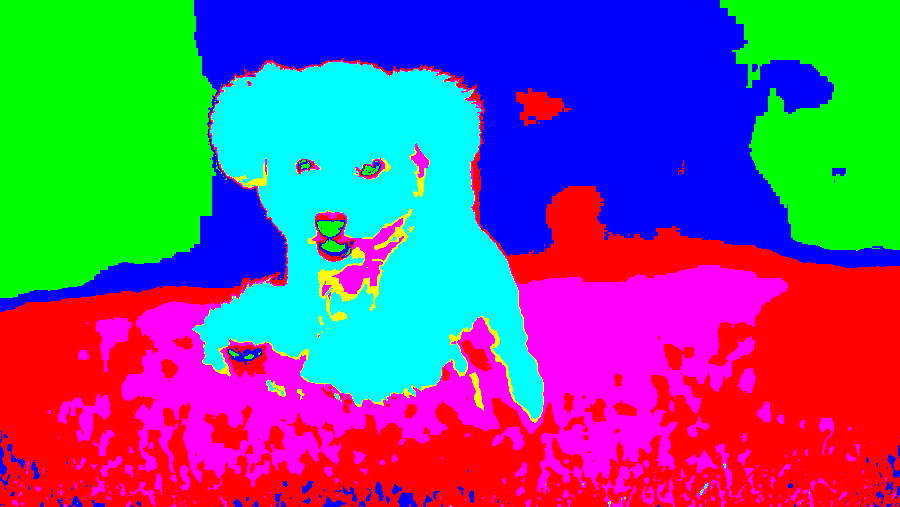




Original Image 2




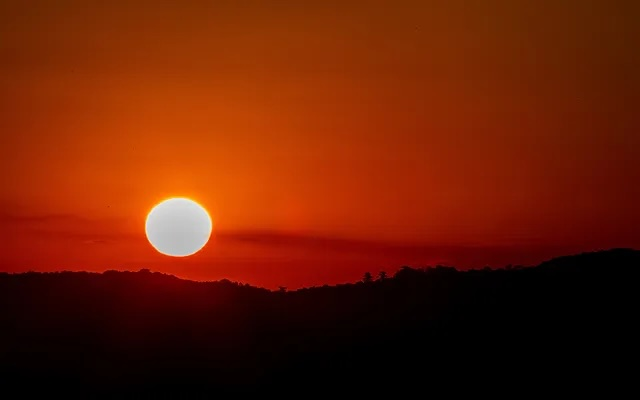






Image: 2 , Number of segments: 3




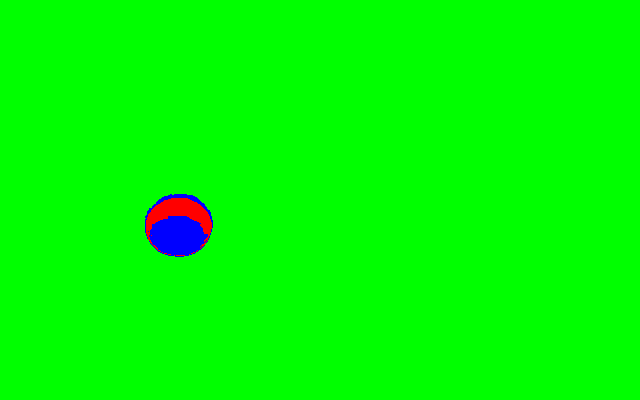




Image: 2 , Number of segments: 4




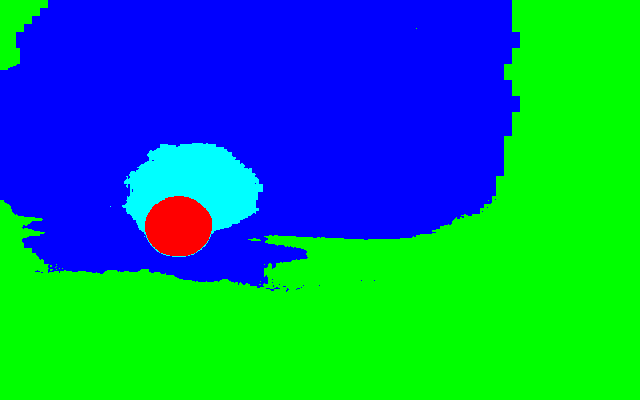




Image: 2 , Number of segments: 5




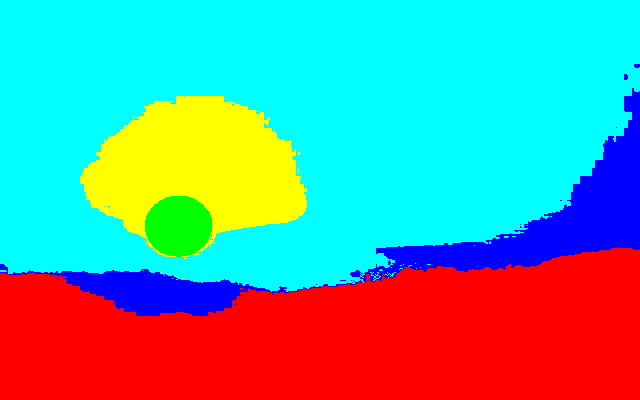




Image: 2 , Number of segments: 6




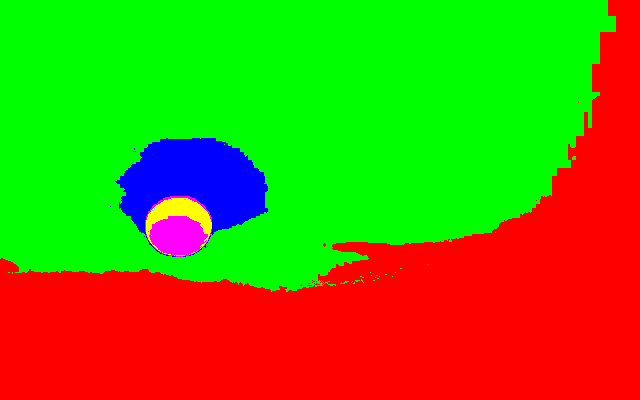




Original Image 3




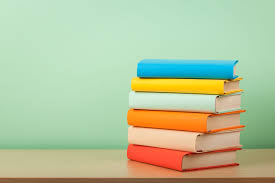






Image: 3 , Number of segments: 3




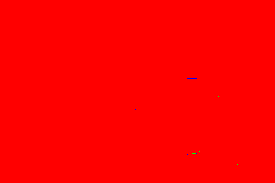




Image: 3 , Number of segments: 4




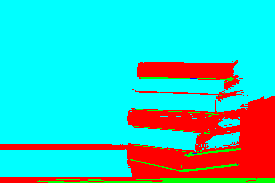




Image: 3 , Number of segments: 5




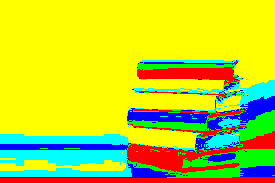




Image: 3 , Number of segments: 6




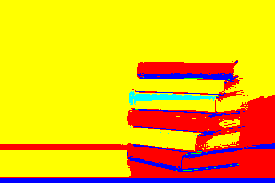




Original Image 4




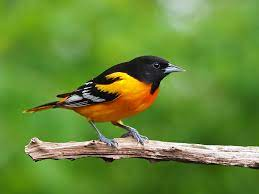






Image: 4 , Number of segments: 3




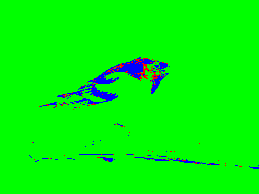




Image: 4 , Number of segments: 4




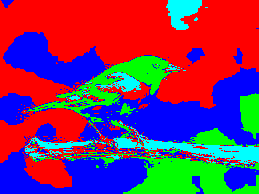




Image: 4 , Number of segments: 5




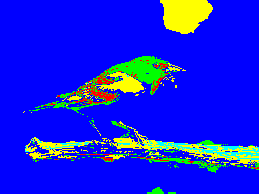




Image: 4 , Number of segments: 6




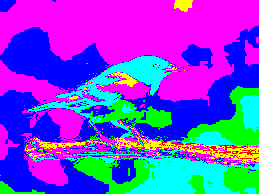

In [ ]:
for i in range(1,5):
  image = cv2.imread(f'/content/img{i}.jpeg')
  print(f"Original Image {i}")
  print('\n')
  cv2_imshow(image)
  print('\n\n\n\n')
  for j in range(3,7):
    segmented_image = k_means_segmented_image(image,j)
    print(f'Image: {i} , Number of segments: {j}')
    print('\n')
    visualise_k_means_segmented_image(segmented_image,image)
    print('\n\n')